In [1]:
import numpy as np
np.set_printoptions(threshold=np.inf)

In [2]:
import re

In [3]:
from scipy.sparse import hstack
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}

# Close the bracket after "train", then add the lines=True argument
train_df = pd.read_json("hf://datasets/sh0416/ag_news/" + splits["train"], lines=True)
test_df = pd.read_json("hf://datasets/sh0416/ag_news/" + splits["test"], lines=True)


In [5]:
train_df['description'] = train_df['description'].apply(lambda x: re.sub("&lt.*?/.*?&gt;", "", x))
test_df['description'] = test_df['description'].apply(lambda x: re.sub("&lt.*?/.*?&gt;", "", x))

In [6]:
target_names = ["World", "Sports", "Business", "Sci/Tech"]
X = train_df[["title", "description"]]
y = train_df["label"]
y_test = test_df["label"]

X_train, X_dev, y_train, y_dev = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
    stratify=y
)


In [7]:
# We could also add min_df=2 to remove words that appear less than 2 times.
# I tried it and doesn't really change our results.
# 'ascii' uses NFKD normalization from unicodedata.normalize.
title_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1),strip_accents= 'ascii')
desc_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1),strip_accents= 'ascii')

X_train_title = title_vectorizer.fit_transform(X_train["title"])
X_train_desc = desc_vectorizer.fit_transform(X_train["description"])

In [8]:
X_dev_title = title_vectorizer.transform(X_dev["title"])
X_dev_desc = desc_vectorizer.transform(X_dev["description"])

X_test_title = title_vectorizer.transform(test_df["title"])
X_test_desc = desc_vectorizer.transform(test_df["description"])

In [9]:
X_train = hstack([X_train_title, X_train_desc])
X_dev = hstack([X_dev_title, X_dev_desc])
X_test = hstack([X_test_title, X_test_desc])

In [13]:
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)

dev_pred_lr = log_reg.predict(X_dev)
print("Logistic Regression — Dev Set Performance")
print(classification_report(y_dev, dev_pred_lr, target_names=target_names))

Logistic Regression — Dev Set Performance
              precision    recall  f1-score   support

       World       0.93      0.91      0.92      3000
      Sports       0.95      0.98      0.97      3000
    Business       0.89      0.88      0.89      3000
    Sci/Tech       0.90      0.90      0.90      3000

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



In [11]:
svm = LinearSVC(max_iter = 10000)
svm.fit(X_train, y_train)

dev_pred_svm = svm.predict(X_dev)
print("Linear SVM — Dev Set Performance")
print(classification_report(y_dev, dev_pred_svm, target_names=target_names))

Linear SVM — Dev Set Performance
              precision    recall  f1-score   support

       World       0.93      0.90      0.92      3000
      Sports       0.96      0.98      0.97      3000
    Business       0.88      0.88      0.88      3000
    Sci/Tech       0.89      0.90      0.89      3000

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



Logistic Regression — Test Set Performance
              precision    recall  f1-score   support

       World       0.93      0.91      0.92      1900
      Sports       0.95      0.98      0.97      1900
    Business       0.88      0.87      0.88      1900
    Sci/Tech       0.89      0.90      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



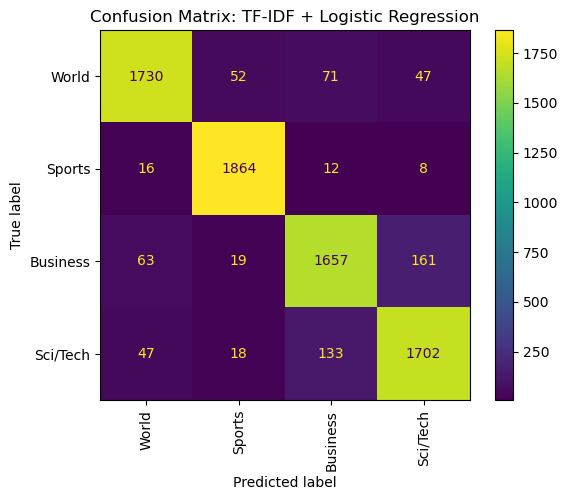

In [14]:
test_pred_lr = log_reg.predict(X_test)
print("Logistic Regression — Test Set Performance")
print(classification_report(y_test, test_pred_lr, target_names=target_names))

cm = confusion_matrix(y_test, test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix: TF-IDF + Logistic Regression")
plt.show()

SVM — Test Set Performance
              precision    recall  f1-score   support

       World       0.92      0.91      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.88      0.87      0.88      1900
    Sci/Tech       0.89      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



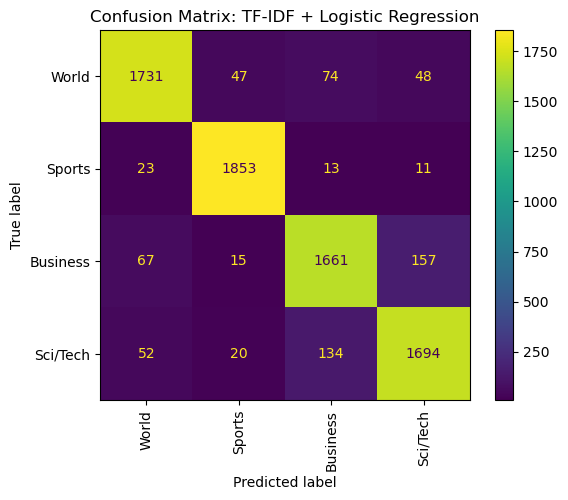

In [16]:
test_pred_svm = svm.predict(X_test)
print("SVM — Test Set Performance")
print(classification_report(y_test, test_pred_svm, target_names=target_names))

cm = confusion_matrix(y_test, test_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix: TF-IDF + Logistic Regression")
plt.show()

In [21]:
# Annalyse lexical similarity.
combined_text = test_df['title'] + " - " + test_df['description']

df_predictions = pd.DataFrame({
    'text': combined_text,
    'true_label': [target_names[i-1] for i in y_test],
    'pred_label': [target_names[i-1] for i in test_pred_lr]
})

errors = df_predictions[df_predictions['true_label'] != df_predictions['pred_label']]

print(f"Total Errors: {len(errors)}")
print("Displaying first 20 misclassifications of the Logistic Regression model:")

#pd.set_option('display.max_colwidth', 150)
display(errors.head(20))

Total Errors: 647
Displaying first 20 misclassifications of the Logistic Regression model:


,text,true_label,pred_label
3,Prediction Unit Helps Forecast Wildfires (AP) ...,Sci/Tech,Sports
9,"Card fraud unit nets 36,000 cards - In its fir...",Sci/Tech,Business
20,IBM to hire even more new workers - By the end...,Sci/Tech,Business
23,Some People Not Eligible to Get in on Google I...,Sci/Tech,Business
24,Rivals Try to Turn Tables on Charles Schwab - ...,Sci/Tech,Business
41,Retailers Vie for Back-To-School Buyers (Reute...,Business,Sci/Tech
47,Dell Exits Low-End China Consumer PC Market - ...,Sci/Tech,Business
56,India's Tata expands regional footprint via Na...,World,Business
79,Live: Olympics day four - Richard Faulds and S...,World,Sports
83,Intel to delay product aimed for high-definiti...,Business,Sci/Tech


In [22]:
df_predictions = pd.DataFrame({
    'text': combined_text,
    'true_label': [target_names[i-1] for i in y_test],
    'pred_label': [target_names[i-1] for i in test_pred_svm]
})

errors = df_predictions[df_predictions['true_label'] != df_predictions['pred_label']]

print(f"Total Errors: {len(errors)}")
print("Displaying first 20 misclassifications of the SVM model:")

#pd.set_option('display.max_colwidth', 150)
display(errors.head(20))

Total Errors: 661
Displaying first 20 misclassifications of the SVM model:


,text,true_label,pred_label
3,Prediction Unit Helps Forecast Wildfires (AP) ...,Sci/Tech,Sports
9,"Card fraud unit nets 36,000 cards - In its fir...",Sci/Tech,Business
20,IBM to hire even more new workers - By the end...,Sci/Tech,Business
23,Some People Not Eligible to Get in on Google I...,Sci/Tech,Business
24,Rivals Try to Turn Tables on Charles Schwab - ...,Sci/Tech,Business
47,Dell Exits Low-End China Consumer PC Market - ...,Sci/Tech,Business
56,India's Tata expands regional footprint via Na...,World,Business
61,Haas and Cink Selected for Ryder Cup Team - Ja...,Sports,World
79,Live: Olympics day four - Richard Faulds and S...,World,Sports
83,Intel to delay product aimed for high-definiti...,Business,Sci/Tech
